# 2da Iteración
En esta oportunidad se busca dar más importancia a los incendios. Según la reunión pasada se indica que para lograrlo, se puede usar *undersampling*.

Adicionalmente, se propone:
- Utilizar una ponderación de los índices investigados hasta la fecha e incluirlos como factores del modelo
- Identificar eventos en donde se asume no habrán incendios (como por ejemplo en la noche) y sólo en esos casos etiquetar el valor como 0
- Evaluar la inclusión de las distancias a los incendios

## Índices
Los índices investigados y aplicados han sido:
- Índice de Riesgo de Incendios de G. Julio
- Risco de Fogo (método brasileño)
- FWI (método canadiense)
    - Este método no se incluirá ya que no aporta información relevante

In [1]:
# Utilities

%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import json
from datetime import datetime

def date(date):
    return datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

def load_data(filename):
    with open(filename) as f:
        data = sorted([{**e, 'ts': date(e['ts']), 'jots': date(e['jots'])}
                       for e in json.load(f)],
                       key=lambda x: x['ts'])
    for d in data:
        for w in d['wildfires']:
            w['start'] = date(w['start'])
            w['end'] = date(w['end'])
    return data

In [2]:
d1 = load_data('dataZ1.json')
d2 = load_data('dataZ2.json')
d3 = load_data('dataZ3.json')

**Formato (campos relevantes):**
```
{
    "ts": timestamp,
    "rf": risco,
    "tmp": temperature [C],
    "hum": humidity [%],
    "prec": precipitation (day) [mm],
    "prec7": precipitation (week) [mm],
    "prec30": precipitation (month) [mm],
    "wnd": wind speed [km/h],
    "julio": julio,
    "jots": original timestamp (julio),
    "wildfires": [
        {
            "lat": latitude,
            "lon": longitude,
            "start": timestamp (wildfire start),
            "duration": wildfire duration [hour],
            "cause": cause classification,
            "distance_to": {
                station_code: distance [mt]
            },
            "end": wildfire extintion (start + duration)
        },
        ...
    ],
    
}
```

**Notas:**
- Cuando no se sabe la duración, o es <1hora, por defecto se considera de 1 hora
- Sólo hay una estación disponible a la fecha: "330007"


In [3]:
# Show format (find one with len(wildfires) > 0)
for d in d3:
    if len(d['wildfires']) > 0:
        print(d)
        break

{'ts': datetime.datetime(2013, 8, 23, 22, 0), 'A': 1.5, 'pse': 70.85959260720432, 'rb': 0.576157771246545, 'rf': 0.29432904512575503, 'tmp': 8.4, 'hum': 88.0, 'prec': 0.0, 'prec7': 0.0, 'prec30': 31.4, 'wnd': 5.0, 'wildfires': [{'lat': -33.07972222222222, 'lon': -71.59805555555555, 'start': datetime.datetime(2013, 8, 23, 22, 0), 'duration': 59.6, 'cause': '2.1.1. Pirómano (insano mental que disfruta del fuego)', 'distance_to': {'330007': 3985.53936753603}, 'end': datetime.datetime(2013, 8, 26, 9, 36)}], 'julio': 3.1683316350490207, 'jots': datetime.datetime(2013, 8, 23, 22, 0)}


De la iteración anterior se sabe que cada zona tiene una cantidad asociada de incendios:
- Zona 1: 20
- Zona 2: 85
- Zona 3: 436

En esta iteración, se pueden repetir los incendios por cada instancia de datos capturados ya que ahora se sabe la duración de cada incendio:

In [4]:
def print_wildfire_stats(z, tag):
    # Zone 'z' data
    print('Total Zona {}:'.format(tag), end=' ')
    print(sum(len(d['wildfires']) for d in z))

print_wildfire_stats(d1, 1)
print_wildfire_stats(d2, 2)
print_wildfire_stats(d3, 3)

Total Zona 1: 81
Total Zona 2: 1196
Total Zona 3: 5905


**Nota:**
Hay ocasiones en que los incendios duran poco más de 1 mes. Debieran ser acortados?

## Análisis de distribución de distancias

    plt.figure(figsize=(20,10))
    plt.tick_params(labelsize=12)
    plot_fn(*args, **kwargs)
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.show()

In [8]:
def plot_distance_bar(z, save=None):
    dist_tab = {}
    for d in z:
        for w in d['wildfires']:
            k = round(w['distance_to']['330007'])
            if k in dist_tab:
                dist_tab[k] += 1
            else:
                dist_tab[k] = 1

    dist_x = np.array([x for x in dist_tab.keys()])
    dist_y = np.array([y for y in dist_tab.values()])
    
    avg = sum(dist_x * dist_y) / sum(dist_y)
    
    distances = []
    for d in z:
        for w in d["wildfires"]:
            distances.append(w["distance_to"]["330007"])
    
    plt.figure(figsize=(20,10))
    plt.tick_params(labelsize=20)
    plt.title("Zona 3: Histograma distancias Foco-Estación", fontsize=30)
    #plt.bar(x=dist_x, width=100, height=dist_y, log=True)
    plt.hist(np.array(distances), 20, edgecolor="black", lw=3, fc=(0, 0, 1, .5), log=True)
    plt.xlabel('Distancia [m]', fontsize=24)
    plt.ylabel('Frecuencia', fontsize=24)
    print('Distance Average: {}m'.format(round(avg, 2)))
    if save is not None:
        plt.savefig(save)
    plt.show()

Zone 1
Distance Average: 1008.63m


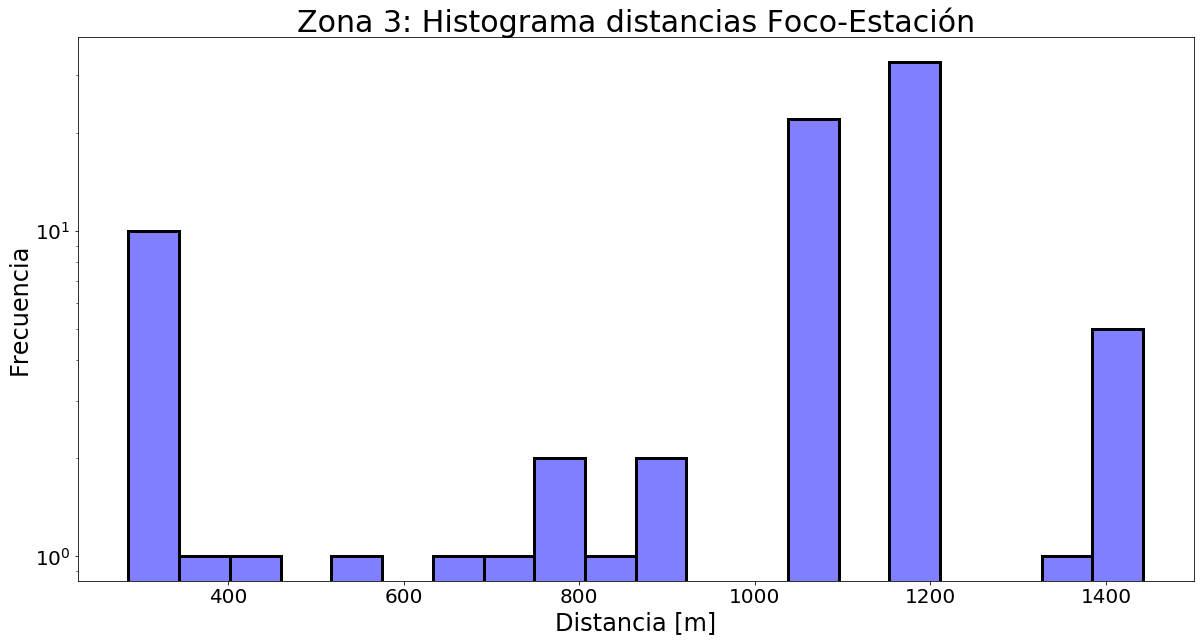

Zone 2
Distance Average: 3296.51m


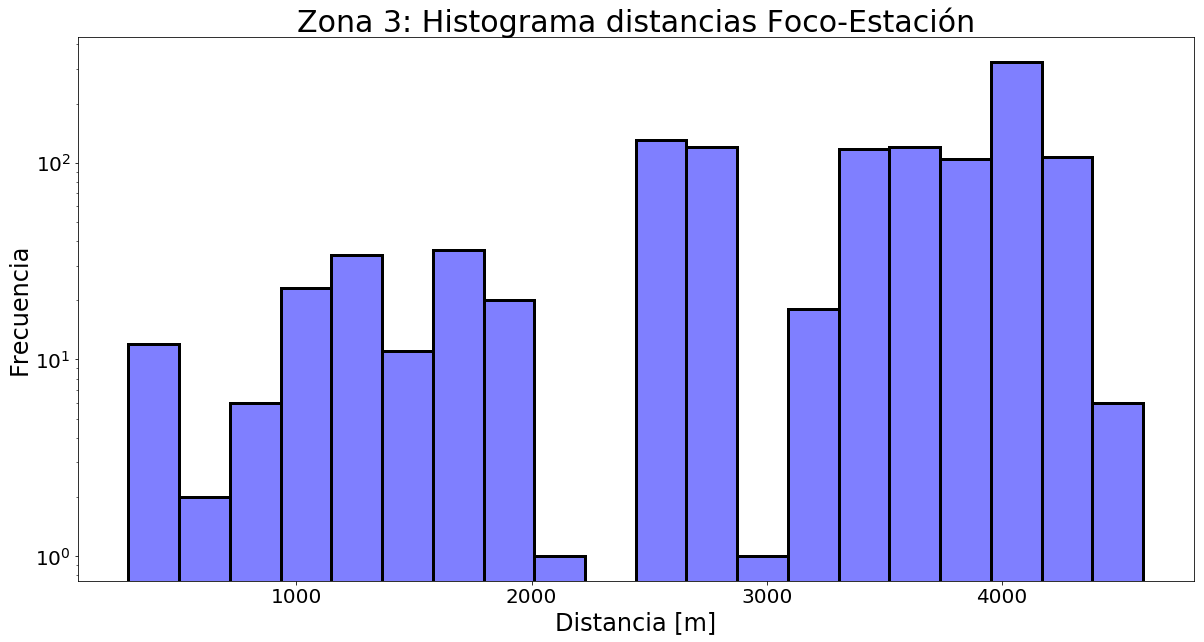

Zone 3
Distance Average: 5822.16m


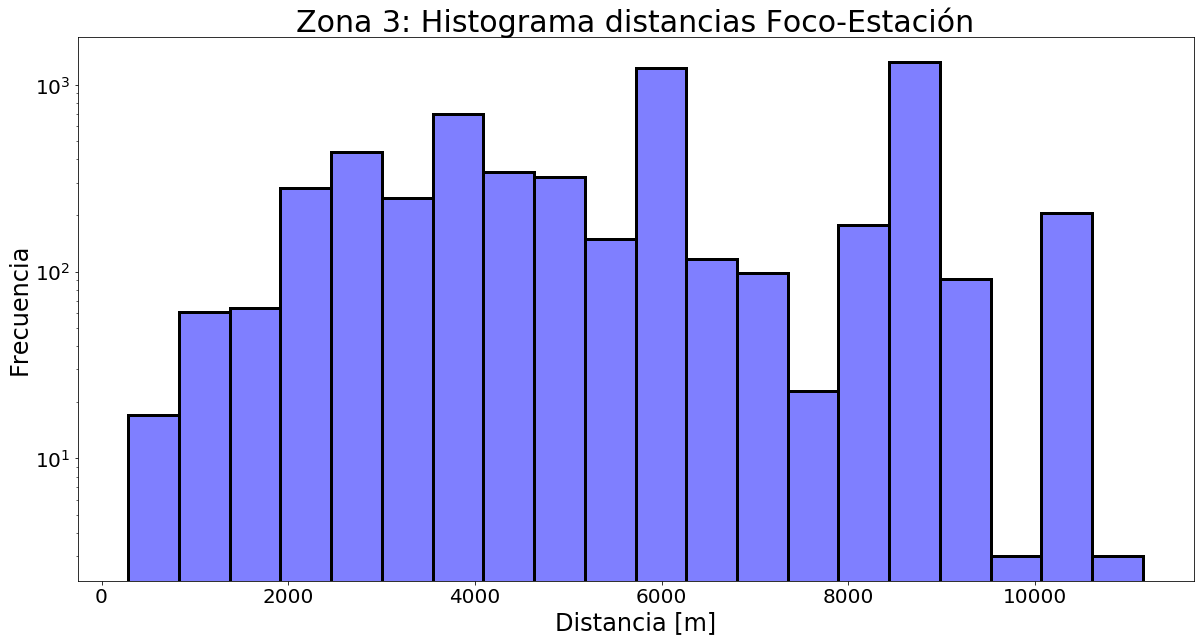

In [9]:
print('Zone 1')
plot_distance_bar(d1)

print('Zone 2')
plot_distance_bar(d2)

print('Zone 3')
plot_distance_bar(d3, 'dist-foco-est.png')

## Análisis de ocurerncia de incendios

Se obtiene visualmente que la mayoría de los incendios ocurren en el período *Nov-May*.

[http://memoria.rcastill.me/memviz/](http://memoria.rcastill.me/memviz/)

**Cantidad de incendios por hora (cuando hay incendios):**

In [13]:
def plot_wild_count_bar(z, save=None):
    wild_tab = {}
    gg = []
    for d in z:
        l = len(d['wildfires'])
        if l > 0:
            gg.append(l)
            if l in wild_tab:
                wild_tab[l] += 1
            else:
                wild_tab[l] = 1

    wild_x = np.array([x for x in wild_tab.keys()])
    wild_y = np.array([y for y in wild_tab.values()])
    
    avg = sum(wild_x * wild_y) / sum(wild_y)
    
    plt.figure(figsize=(20,10))
    plt.tick_params(labelsize=20)
    plt.title("Zona 3: Ocurrencia de Incendios por Registro", fontsize=30)
    plt.bar(x=wild_x, height=wild_y)
    plt.xticks(wild_x)
    plt.xlabel('Incendios [unidad]', fontsize=24)
    plt.ylabel('Ocurrencias', fontsize=24)
    print('Wildfire Count Average: {} wildfires; {}'.format(avg, sum(gg)/len(gg)))
    if save is not None:
        plt.savefig(save)
    plt.show()

def plot_wild_hour_bar(z, filterf=lambda _: True, save=None):
    wild_tab = {}
    for d in z:
        for w in d['wildfires']:
            if filterf(w):
                k = w['start'].hour
                if k in wild_tab:
                    wild_tab[k] += 1
                else:
                    wild_tab[k] = 1

    wild_x = np.array([x for x in wild_tab.keys()])
    wild_y = np.array([y for y in wild_tab.values()])
    
    avg = sum(wild_x * wild_y) / sum(wild_y)

    plt.figure(figsize=(20,10))
    plt.tick_params(labelsize=20)
    plt.title("Zona 3: Ocurrencia de Incendios por Hora", fontsize=30)
    plt.bar(x=wild_x, height=wild_y)
    plt.xticks(wild_x)
    plt.xlabel('Inicio del Incendio (hora)', fontsize=24)
    plt.ylabel('Ocurrencias', fontsize=24)
    print('Wildfire Start Average: {}hrs'.format(round(avg, 2)))
    if save is not None:
        plt.savefig(save)
    plt.show()

Zone 1
Wildfire Count Average: 1.0 wildfires; 1.0


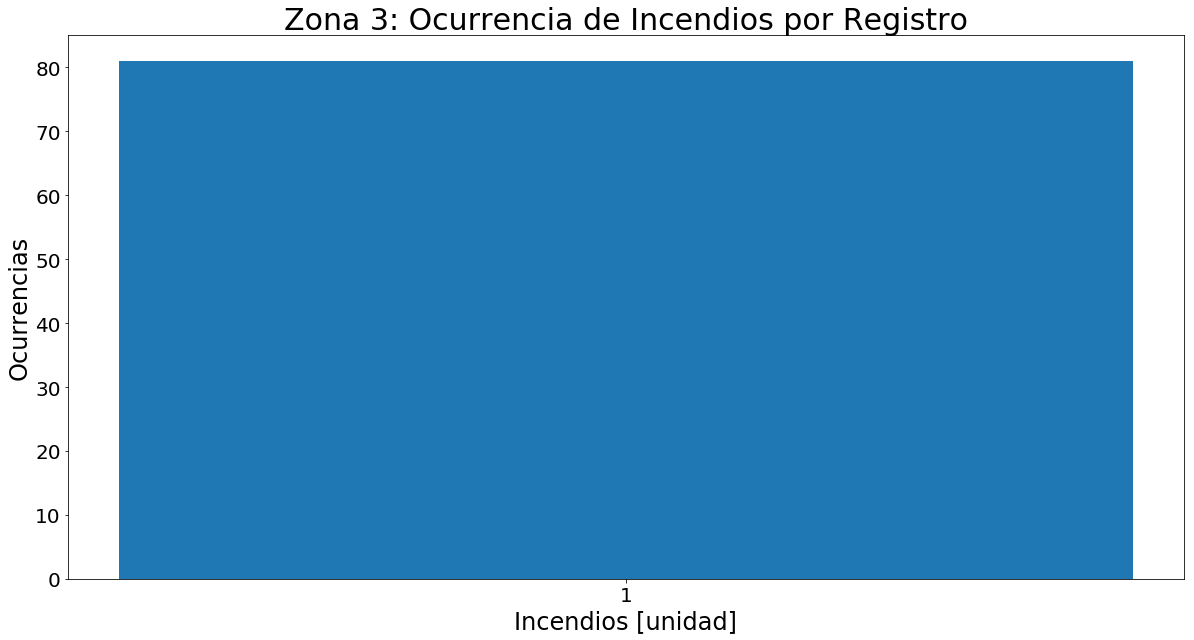

Zone 2
Wildfire Count Average: 1.2791443850267379 wildfires; 1.2791443850267379


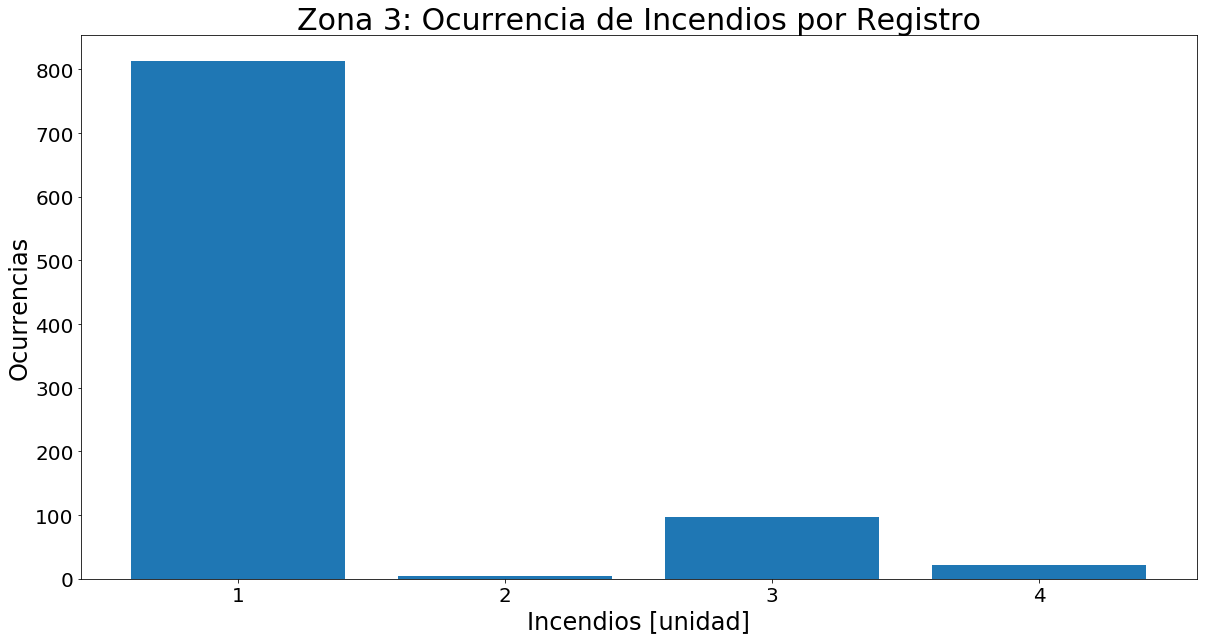

Zone 3
Wildfire Count Average: 1.2767567567567568 wildfires; 1.2767567567567568


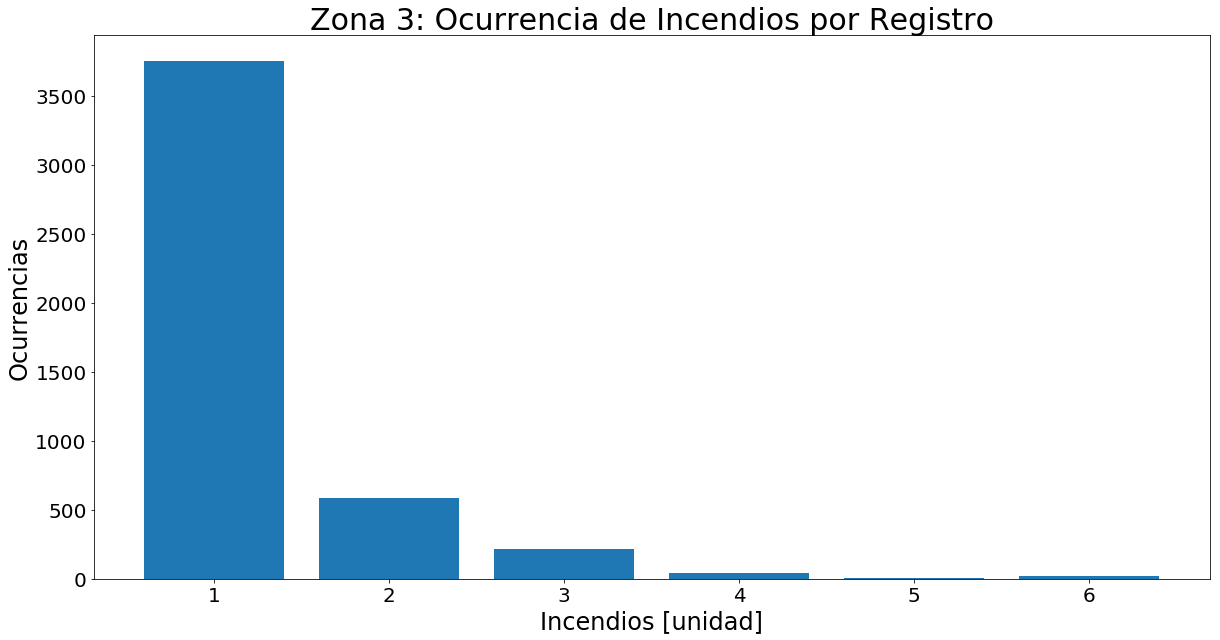

In [15]:
print('Zone 1')
plot_wild_count_bar(d1)

print('Zone 2')
plot_wild_count_bar(d2)

print('Zone 3')
plot_wild_count_bar(d3, 'wildfire-per-register-z3.png')

**Distribución horaria de incendios**

Zone 1
Wildfire Start Average: 10.81hrs


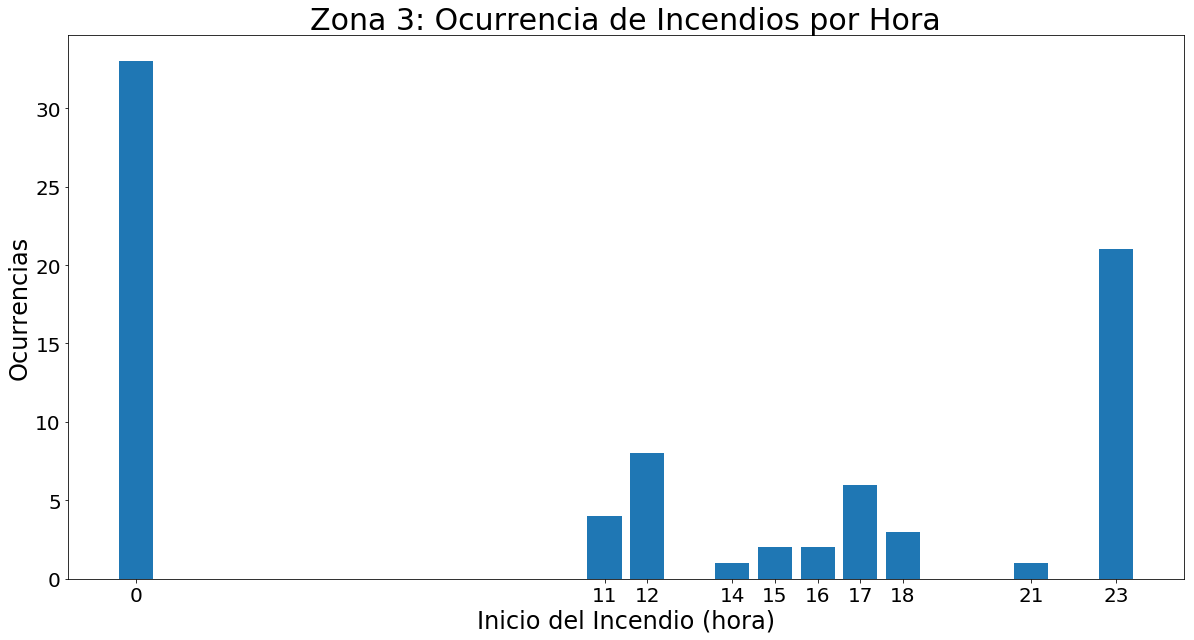

Zone 2
Wildfire Start Average: 15.29hrs


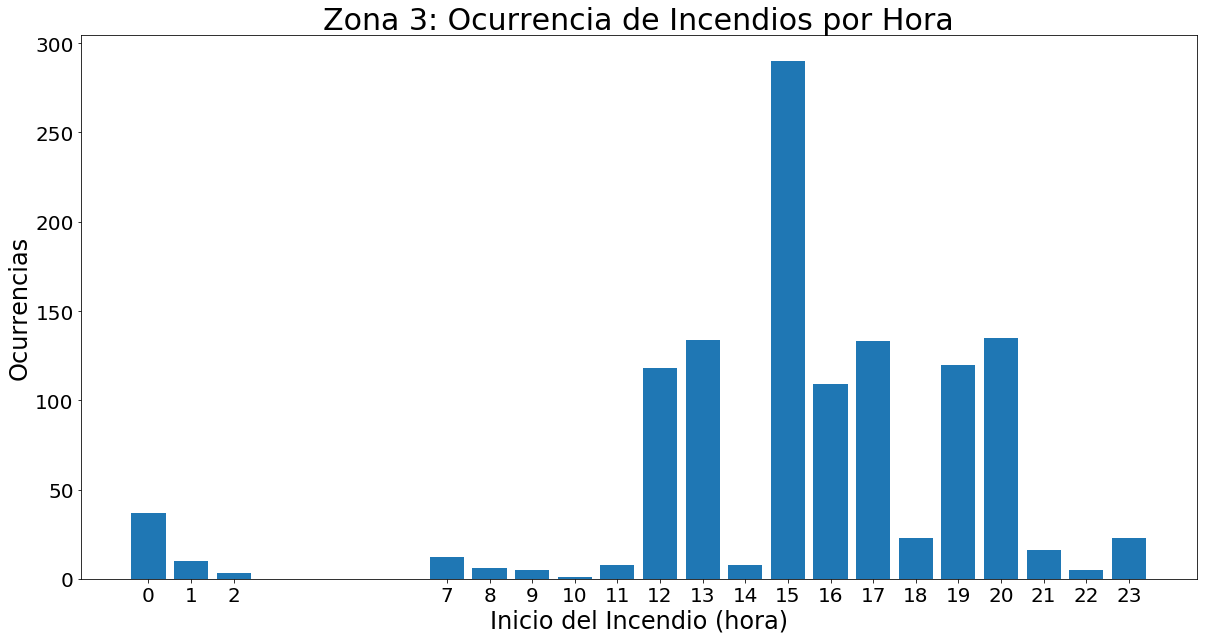

Zone 3
Wildfire Start Average: 15.19hrs


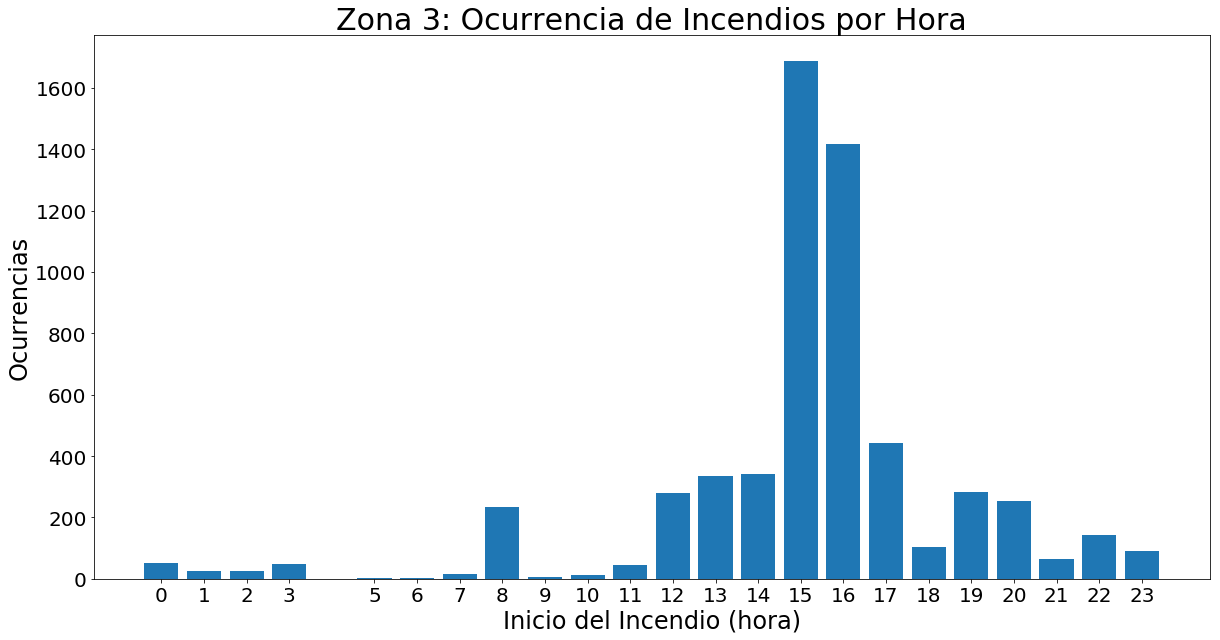

In [17]:
print('Zone 1')
plot_wild_hour_bar(d1)

print('Zone 2')
plot_wild_hour_bar(d2)

print('Zone 3')
plot_wild_hour_bar(d3, save='wildfires-per-hour-z3.png')

**Análisis de causas**

In [49]:
causes = set()
# Z3 es superset
for d in d3:
    for w in d['wildfires']:
        causes.add(w['cause'])
print('Total:', len(causes))
for c in causes:
    print(c)

Total: 18
1.6.3. Incendio estructural (campamento forestal  casa habitación u otras edificaciones)
1.9.4. Corte de cable por otro accidente o acción no clasificada
1.1.2. Quema ilegal de desechos de cosecha forestal (quema para reforestación)
1.9.3. Corte de cable por caí­da de tendido eléctrico o postación
1.4.5. Niños jugando con fuego
1.7.3. Accidente o incendio de vehí­culo en tránsito
1.10.5. Soldadura y montaje de estructuras varias (torres de alta tensión  oleoductos  etc.)
1.8.14. Encendido de vertederos o basurales autorizados 
2.1.11. Otros intencionales no clasificados
2.1.1. Pirómano (insano mental que disfruta del fuego)
1.7.1. Uso de fuego por transeúntes
1.1.5. Quema legal de habilitación de terreno forestal (quema para forestación)
4.1.1. Desconocida (se investiga pero no es posible establecer la causa origen)
3.1.1. Caí­da de rayo
1.8.2. Quema legal de aserrí­n o aserrí­n encendido
1.4.1. Uso de fuego para actividades recreativas en áreas no habilitadas  (excursionista

A partir de lo anterior se puede discernir entre *legal* e *ilegal*:

In [83]:
def islegal(w):
    return w['cause'].split()[0] in ['1.8.2.',
                                     '1.1.5.',
                                     '1.8.14.',
                                     '1.8.1.']

In [89]:
print('Legal/Ilegal Ratio:', end=' ')
legal = 0
ilegal = 0
for d in d3:
    for w in d['wildfires']:
        if islegal(w):
            legal += 1
        else:
            ilegal += 1
print('{}/{} ({}%)'.format(legal, ilegal, legal*100/(legal+ilegal)))
legal+ilegal

Legal/Ilegal Ratio: 422/5483 (7.146486028789162%)


5905

**Distribución horaria de incendios (sólo ilegales)**

Zone 1
Wildfire Start Average: 10.81hrs


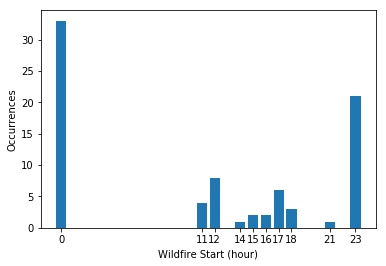

Zone 2
Wildfire Start Average: 15.35hrs


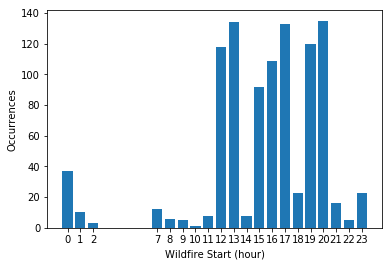

Zone 3
Wildfire Start Average: 15.49hrs


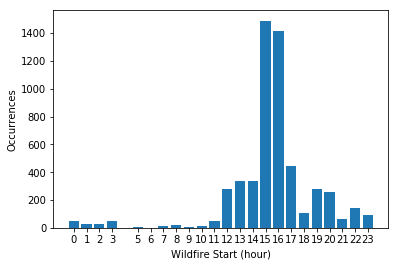

In [52]:
print('Zone 1')
plot_wild_hour_bar(d1, lambda w: not islegal(w))

print('Zone 2')
plot_wild_hour_bar(d2, lambda w: not islegal(w))

print('Zone 3')
plot_wild_hour_bar(d3, lambda w: not islegal(w))

*No existe una variación considerable al considerar la combinación de casos*

In [53]:
def only_legal(d):
    '''
    Obtener instancias en las que existe sólo 1 incendio
    y es legal
    '''
    if len(d['wildfires']) > 0:
        if len([w for w in d['wildfires'] if islegal(w)]) == len(d['wildfires']):
            return True
    return False

def least_legal(d):
    '''
    Obtener instancias en las que el incendio más cercano
    es legal
    '''
    if len(d['wildfires']) > 0:
        least = d['wildfires'][0]['distance_to']['330007']
        legal = islegal(d['wildfires'][0])
        for w in d['wildfires'][1:]:
            if w['distance_to']['330007'] < least:
                least = w['distance_to']['330007']
                legal = islegal(w)
        return legal
    return False


In [54]:
only_legal_count = len([d for d in d3 if only_legal(d)])
print('No. only legal wildfires:', only_legal_count)

least_legal_count = len([d for d in d3 if least_legal(d)])
print('No. wildfires with least_legal_count:', least_legal_count)

No. only legal wildfires: 400
No. wildfires with least_legal_count: 420


## Criterios de etiquetado

Considerando los datos anteriores se desarrolla el siguiente criterio:

- Si la quema más cercana es legal, la etiqueta será 0.0
    - Se usa este método yq que, aunque más agresivo, la diferencia es poca
- Se asume que de noche las condiciones no son propicias para que inicie un incendio
    - Se propone una discusión al respecto dado que existen instancias en las que si se dan incendios
    - Para Z1: `01:00-10:00`
    - Para Z2: `01:00-06:00`
    - Para Z3: `01:00-10:00`
- Cuando hay incendios:
    - Si la cantidad de incendios es >ceil(avg), la etiqueta será 1.0
    - Luego, si la distancia min <avg, la etiqueta será 1.0
    - Luego, si la distancia min >avg, la etiqueta se comportará de manera lineal desde 0.9 a 0.99
- Cuando no hay incendios:
    - Se hace una ponderación de los índices de incendios: 0.9 * (0.8 * rf + julio * 0.2/100); esto permite que los valores fluctúen entre 0 y 0.9
- Si es necesario, se ejecutará undersampling, utilizando sólo datos de noviembre a mayo

In [92]:
def wild_count_dist_mean(z):
    wild_count = []
    wild_dist = []
    for d in z:
        l = len([w for w in d['wildfires']
                 if not islegal(w)])
        if l > 0:
            wild_count.append(l)
        wild_dist.extend([w['distance_to']['330007']
                          for w in d['wildfires']])
    return np.mean(wild_count), np.mean(wild_dist)

In [93]:
# Get needed variables
avgc1, avgd1 = wild_count_dist_mean(d1)
avgc2, avgd2 = wild_count_dist_mean(d2)
avgc3, avgd3 = wild_count_dist_mean(d3)

In [94]:
avgc3

1.2977514792899407

In [95]:
avgd3

5822.044269656557

In [96]:
# y - y1 = m(x - x1)
# y = mx + (y1 - m*x1)
def mk_wildfire_line(z, avg):
    # max distance
    x1 = avg
    y1 = 0.9
    
    # minimum distance
    x2 = avg
    y2 = 0.99
    
    for d in z:
        for w in d['wildfires']:
            dist = w['distance_to']['330007']
            if dist >= x1:
                x1 = dist
    
    m = (y2 - y1) / (x2 - x1)
    y0 = y1 - m * x1
    
    return lambda x: m * x + y0

def indcomb(rf, julio):
    if rf > 1:
        rf = 1
    elif rf < 0:
        rf = 0
    if julio > 100:
        julio = 100
    elif julio < 0:
        julio = 0
    return 0.9 * (0.8 * rf + 0.2 * (julio/100))

def mark(z, nightfr, nightto, avgc, avgd):
    wline = mk_wildfire_line(z, avgd)
    for d in z:
        notlegal = [w for w in d['wildfires'] if not islegal(w)]
        if len(notlegal) > 0:
            min_dist = min([w['distance_to']['330007'] for w in notlegal])
        else:
            min_dist = -1
        if least_legal(d):
            d['mark'] = 0.0
        elif d['ts'].hour >= nightfr and d['ts'].hour <= nightto:
            d['mark'] = 0.0
        elif len(notlegal) > int(np.ceil(avgc)):
            d['mark'] = 1.0
        elif min_dist >= 0 and min_dist < avgd:
            d['mark'] = 1.0
        elif min_dist >= avgd:
            d['mark'] = wline(min_dist)
        else:
            if d['jots'] == d['ts']:
                d['mark'] = indcomb(d['rf'], d['julio'])
            else:
                d['mark'] = 0.9 * min(max(0, d['rf']), 100)

In [97]:
td1 = d1[:]
td2 = d2[:]
td3 = d3[:]

In [98]:
# Training data
mark(td1, 1, 10, avgc1, avgd1)
mark(td2, 1, 6, avgc2, avgd2)
mark(td3, 1, 10, avgc3, avgd3)

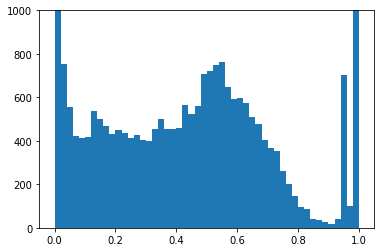

In [99]:
plt.hist([d['mark'] for d in td3], 50)
plt.ylim(0, 1000)
plt.show()

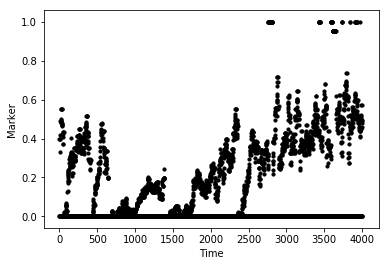

In [100]:
# Draw first 200 expected markers
for i, d in enumerate(td3[:4000]):
    plt.scatter(i, d['mark'], color='black', s=10, marker='o')
plt.xlabel('Time')
plt.ylabel('Marker')
plt.show()

Convert data to tensor representation

In [101]:
import torch

def to_tensor_x(data):
    return torch.FloatTensor(
        [[d['ts'].month, d['tmp'],
          d['hum'], d['prec7'],
          d['wnd']] for d in data])

def to_tensor_y(data):
    return torch.FloatTensor([[d['mark']] for d in data])

def to_data(data, predicted):
    for d, y in zip(data, predicted):
        yield {
            **d,
            'ind': y.item()
        }

def std(data):
    '''
    Standarize
    '''
    means = np.mean(data.numpy(), axis=0, keepdims=True)
    std = np.std(data.numpy(), axis=0, keepdims=True)
    return torch.from_numpy((data.numpy() - means) / std)

def norm(data):
    '''
    Normalize
    '''
    mins = np.min(data.numpy(), axis=0, keepdims=True)
    maxs = np.max(data.numpy(), axis=0, keepdims=True)
    return torch.from_numpy((data.numpy()-mins)/(maxs-mins))

In [102]:
# train data for Z1
x1 = to_tensor_x(td1)
y1 = to_tensor_y(td1)

# train data for Z2
x2 = to_tensor_x(td2)
y2 = to_tensor_y(td2)

# train data for Z3
x3 = to_tensor_x(td3)
y3 = to_tensor_y(td3)

In [103]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        # 7 inputs, 1 output
        self.linear = torch.nn.Linear(5, 1)
        #self.layer2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        y_pred = self.linear(x)
        #y_pred = self.layer2(torch.nn.ReLU()(self.linear(x)))
        return y_pred

class NonLinearModel(torch.nn.Module):
    def __init__(self, hidden_dim=2):
        super(NonLinearModel, self).__init__()
        self.layer1 = torch.nn.Linear(5, hidden_dim)
        self.layer2 = torch.nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        return self.layer2(torch.nn.ReLU()(self.layer1(x)))

mse_loss = torch.nn.MSELoss(size_average=False)

def sgd(model_params):
    return torch.optim.SGD(model_params, lr=0.01)

def adam(model_params):
    return torch.optim.Adam(model_params, lr=0.01)

def train(model, train_x, train_y, *, iterations=500, criterion=mse_loss, mkoptimizer=sgd):
    '''
    Example:
        train(LinearModel(), x, y, criterion=torch.nn.SmoothL1Loss(),
            mkoptimizer=lambda p: torch.optim.Adam(p, lr=0.01))
    '''
    optimizer = mkoptimizer(model.parameters())
    for epoch in range(iterations):
        y_pred = model(train_x)
        loss = criterion(y_pred, train_y)
        plt.scatter(epoch, loss.data.item(), color='r', s=10, marker='o')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    plt.show()
    return model

def test_model(model, data, *, extract=2000, xtransform=std):
    x = xtransform(to_tensor_x(data))
    for i, d in enumerate(data[:extract]):
        color = 'r' if len(d['wildfires']) > 0 else 'black'
        plt.scatter(i, d['mark'], color=color, s=10, marker='o')
    for i, y in enumerate(model(x)[:extract]):
        plt.scatter(i, y.item(), color='b', s=10, marker='o')
    plt.show()

/Users/Rodolfo/.virtualenvs/jupyter/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


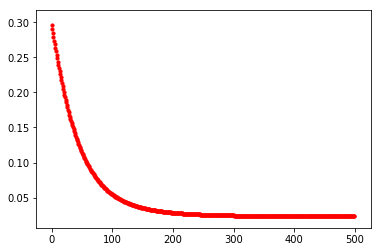

In [104]:
m1lin = train(LinearModel(), std(x1), y1, criterion=torch.nn.SmoothL1Loss())

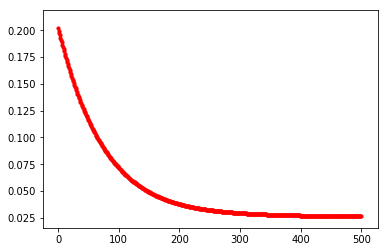

In [105]:
m2lin = train(LinearModel(), std(x2), y2, criterion=torch.nn.SmoothL1Loss())

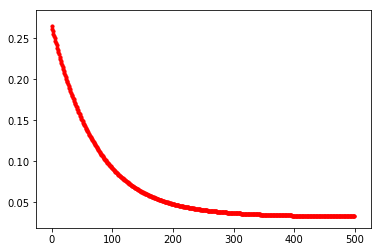

In [106]:
m3lin = train(LinearModel(), std(x3), y3, criterion=torch.nn.SmoothL1Loss())

In [107]:
m3lin.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0074,  0.1216, -0.0433, -0.0460,  0.0065]])),
             ('linear.bias', tensor([0.2503]))])

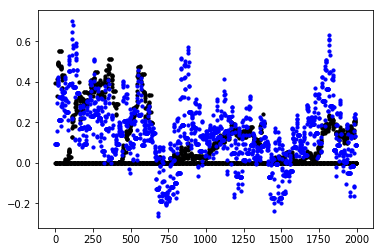

In [28]:
test_model(m1lin, d1)

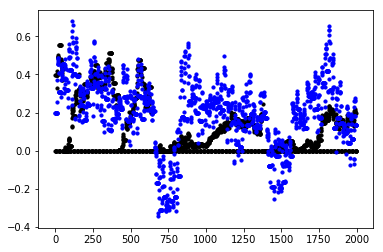

In [29]:
test_model(m2lin, d2)

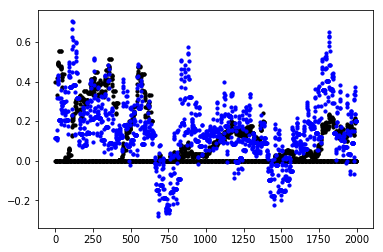

In [30]:
test_model(m3lin, d3)

In [31]:
# save output
def save(z, x, model, filename, xtrans=std):
    with open(filename, 'w') as f:
        y = model(xtrans(x))
        d = [ _ for _ in to_data(z, y)]
        json.dump(d, f, default=lambda x: str(x))
        print('Written to {}'.format(filename))

In [32]:
save(d1, x1, m1lin, 'm1lin.json')

Written to m1lin.json


In [33]:
save(d2, x2, m2lin, 'm2lin.json')

Written to m2lin.json


In [34]:
save(d3, x3, m3lin, 'm3lin.json')

Written to m3lin.json


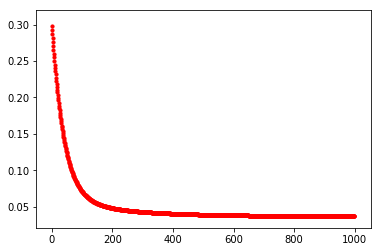

In [35]:
m1non = train(NonLinearModel(), std(x1), y1, criterion=torch.nn.SmoothL1Loss(), iterations=1000)

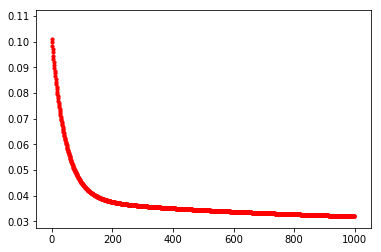

In [44]:
m2non = train(NonLinearModel(), std(x2), y2, criterion=torch.nn.SmoothL1Loss(), iterations=1000)

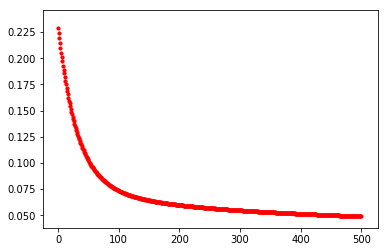

In [108]:
m3non = train(NonLinearModel(), std(x3), y3, criterion=torch.nn.SmoothL1Loss())

In [109]:
m3non.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.3757,  0.4611,  0.2515,  0.1028, -0.1240],
                      [-0.4673, -0.3548,  0.3480,  0.0796,  0.2616]])),
             ('layer1.bias', tensor([0.1895, 0.1297])),
             ('layer2.weight', tensor([[0.2240, 0.0477]])),
             ('layer2.bias', tensor([0.1624]))])

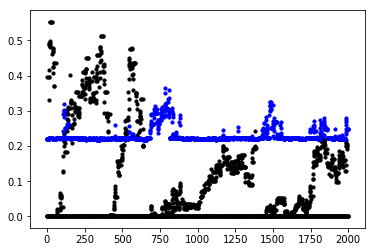

In [38]:
test_model(m1non, d1)

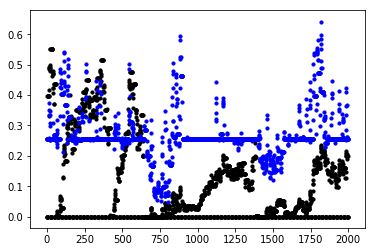

In [45]:
test_model(m2non, d2)

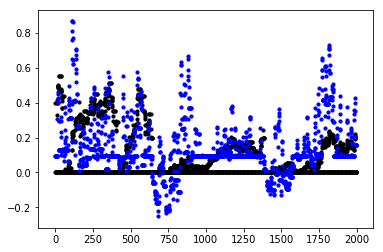

In [40]:
test_model(m3non, d3)

In [41]:
save(d1, x1, m1non, 'm1non.json')

Written to m1non.json


In [46]:
save(d2, x2, m2non, 'm2non.json')

Written to m2non.json


In [43]:
save(d3, x3, m3non, 'm3non.json')

Written to m3non.json
